# Ensemble Learning through Soft Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [2]:
np.random.seed(2020)

In [3]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [4]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [5]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [6]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [7]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0793534441124991

In [8]:
X_test.shape

(50000, 1, 2)

## Compare with Hard voting

In [9]:
from aggregating.models import SoftBagger, SimpleBagger
from aggregating.utils import flatten_X
soft = SoftBagger(3,0.8,GaussianProcessRegressor(kernel,copy_X_train=False))
hard = SimpleBagger(3,0.8,GaussianProcessRegressor(kernel,copy_X_train=False))
soft.fit(flatten_X(X_train),y_train)
hard.fit(flatten_X(X_train),y_train)

fit
(5000, 2)
fit
(5000, 2)


In [10]:
#compare soft & hard prediction
from aggregating.utils import normalized_error_VT
print(normalized_error_VT(y_test, soft.predict(flatten_X(X_test)), V_0))
print(normalized_error_VT(y_test, hard.predict(flatten_X(X_test)), V_0))

 soft predict
(50000, 2)
0.18541639474406327
predict
(50000, 2)
0.172493378482348


In [11]:

x  =  X_test[1023]
for predictor in soft.predictors:
    print(predictor.predict(x,return_std=True))
print(soft.predictors[0].kernel)
print(soft.predictors[1].kernel)

(array([-0.00066049]), array([0.0251005]))
(array([-0.00975121]), array([0.02114459]))
(array([0.00518251]), array([0.01971414]))
RBF(length_scale=39.2) + WhiteKernel(noise_level=2.5)
RBF(length_scale=39.2) + WhiteKernel(noise_level=2.5)


In [12]:
from sklearn.base import clone
gpr1  = GaussianProcessRegressor(kernel,copy_X_train=False)
gpr2  = clone(gpr1)
gpr1.fit(flatten_X(X_train[2:10]),y_train[2:10])
gpr2.fit(flatten_X(X_train[12:20]),y_train[12:20])

print(gpr1.predict(X_test[4],return_std = True))
print(gpr2.predict(X_test[4],return_std = True))

(array([0.11668687]), array([0.05785658]))
(array([0.06577228]), array([0.10983612]))


## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [21]:
#reference error: no ensemble
from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

hyperparams= {'M':1, 'train_size_alpha':1.0}
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],3,N_test,MaxCallStochasticModel)
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 24984
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.11277080067185337
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.1539909005734911
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.1306203677392917
{'M': 1, 'train_size_alpha': 1.0} -> [0.11277080067185337, 0.1539909005734911, 0.1306203677392917]
0.1324606896615454


In [13]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SoftBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [1,3,5,7,9]
alpha_grid = [0.3,0.5,0.7,1.0]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(4) #avoid allocation issues
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



 {'M': 1, 'train_size_alpha': 0.3} -> thread id = 25888
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 30076
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.7} -> thread id = 21960
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 24608
fit
(5000, 2)
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 0 -> 0.20680562753475445
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 1 -> 0.20784594821086247
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.5} , 0 -> 0.1734467229111171
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 2 -> 0.18768481684292143
{'M': 1, 'train_size_alpha': 0.3} -> [0.20680562753475445, 0.20784594821086247, 0.18768481684292143]
 {'M': 3, 'train_size_alpha': 0.3} -> thread id = 25888logger {'M': 1, 'train_size_alpha': 0.3}, -> [0.20680562753475445, 0.20784594821086247, 0.18768481684292143]
fit

(5000, 2)
{'M': 1, 'train_size_a

{'M': 7, 'train_size_alpha': 1.0} , 0 -> 0.2077393870885229
 soft predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.3} , 2 -> 0.1433274923428715
{'M': 9, 'train_size_alpha': 0.3} -> [0.09782762977238432, 0.10893637951889752, 0.1433274923428715]
 {'M': 9, 'train_size_alpha': 0.7} -> thread id = 21960
logger {'M': 9, 'train_size_alpha': 0.3}, -> [0.09782762977238432, 0.10893637951889752, 0.1433274923428715]
fit
(5000, 2)
 soft predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.5}


Traceback (most recent call last):
  File "C:\Users\thoma\School\Machine_learning\ML-Project2\aggregating\gridsearch.py", line 73, in evaluate_model
    y_hat = model.predict(Flattened_X_test)
  File "C:\Users\thoma\School\Machine_learning\ML-Project2\aggregating\models.py", line 150, in predict
    mu,sigma = self.predictors[i].predict(X,return_std=True)
  File "c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py", line 338, in predict
    K_trans = self.kernel_(X, self.X_train_)
  File "c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\kernels.py", line 758, in __call__
    return self.k1(X, Y) + self.k2(X, Y)
  File "c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\kernels.py", line 1435, in __call__
    K = np.exp(-.5 * dists)
MemoryError: Unable to allocate array with shape (50000, 2500) and data type float64


 {'M': 9, 'train_size_alpha': 1.0} -> thread id = 30076logger {'M': 9, 'train_size_alpha': 0.5}, -> None

fit
(5000, 2)
{'M': 7, 'train_size_alpha': 0.7} , 2 -> 0.20631813215659423
{'M': 7, 'train_size_alpha': 0.7} -> [0.16379346513856355, 0.1967568283185929, 0.20631813215659423]
logger {'M': 7, 'train_size_alpha': 0.7}, -> [0.16379346513856355, 0.1967568283185929, 0.20631813215659423]
{'M': 7, 'train_size_alpha': 1.0} , 1 -> 0.17577643636300389
 soft predict
(50000, 2)
{'M': 7, 'train_size_alpha': 1.0} , 2 -> 0.23400615344238251
{'M': 7, 'train_size_alpha': 1.0} -> [0.2077393870885229, 0.17577643636300389, 0.23400615344238251]
logger {'M': 7, 'train_size_alpha': 1.0}, -> [0.2077393870885229, 0.17577643636300389, 0.23400615344238251]
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.7} , 0 -> 0.188856609737082
 soft predict
(50000, 2)
{'M': 9, 'train_size_alpha': 1.0} , 0 -> 0.18741610247725368
 soft predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.7} , 

In [14]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.3, [0.20680562753475445, 0.20784594821086247, 0.18768481684292143]]
[1, 0.5, [0.1734467229111171, 0.21354464978239002, 0.1540395807968068]]
[1, 0.7, [0.18993739315096062, 0.21258929172791619, 0.24963175921125424]]
[1, 1.0, [0.12563957740733717, 0.1449049963540651, 0.13743665614337924]]
[3, 0.3, [0.122467736434133, 0.13842292618438565, 0.12467515706163383]]
[3, 0.5, [0.16730458523152258, 0.21591424646282087, 0.14676676918211617]]
[5, 0.3, [0.12362895057756293, 0.12142890026433463, 0.1407207669980889]]
[3, 0.7, [0.22086353399107875, 0.21595444963644359, 0.16095404239629343]]
[3, 1.0, [0.2328679425756107, 0.2333405585252975, 0.22357558688639417]]
[5, 0.5, [0.19736083832548085, 0.19046795585748202, 0.18231665419957932]]
[7, 0.3, [0.10198899146450748, 0.08235472713153982, 0.12432183431441962]]
[5, 0.7, [0.1742431402273195, 0.17363674328501644, 0.17932723188445335]]
[5, 1.0, [0.18936839956621598, 0.1641360253721725, 0.15848935597777478]]
[7, 0.5, [0.17602005148211514, 0.163913938967012

In [15]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


(5, 4)

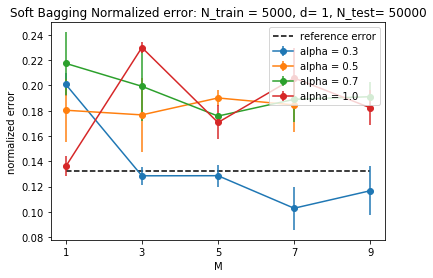

In [24]:
plt.hlines(reference_error_mean,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Soft Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.show()

## Store results

In [17]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [18]:
import json
import datetime
with open(f'soft_bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)